# Minchilla: A minima reproduction of the Chinchilla Scaling Laws

---
**Authors: [Ben Agro](https://benagro314.github.io/) and Sourav Biswas**

---

In this repo we apply Method 2 (IsoFLOP curves) from the Chinchilla Scaling Laws Paper [1]
to **very small transformers** on a **character-level lanugage modelling task** on the TinyStories Dataset [2].


In this setting, we find a result similar to the original paper, namely that parameters and training tokens should be scaled up in
roughly equal proportions.

$$N_{opt} \propto C^{0.48}, \quad D_{opt} \propto C^{0.52}$$
where $D$ is the number of training tokens, $N$ is the number of model parameters, and $C$ is the number of FLOPs available for training.

Please check our repository for more information: https://github.com/BenAgro314/Minchilla


**Citations**:
- [1] [Hoffmann, J., Borgeaud, S., Mensch, A., Buchatskaya, E., Cai, T., Rutherford, E., ... & Sifre, L. (2022). Training compute-optimal large language models. arXiv preprint arXiv:2203.15556.](https://arxiv.org/pdf/2203.15556)
- [2] [Eldan, R., & Li, Y. (2023). Tinystories: How small can language models be and still speak coherent english?. arXiv preprint arXiv:2305.07759.](https://arxiv.org/pdf/2305.07759)

## Install

In [ ]:
# Install libraries
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Standard Library Imports
import argparse
import csv
import json
import math
import os
import sys
import time
import glob

# Third-Party Library Imports
import numpy as np
from sklearn.linear_model import RANSACRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from torch.utils.data import DataLoader, Dataset, Sampler
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.tensorboard import SummaryWriter

## Setup Dataset and Dataloader

In [ ]:
# datasets and dataloaders
class TokenLimitedSampler(Sampler):
    def __init__(self, data_source, num_tokens):
        self.data_source = data_source
        self.num_tokens = num_tokens

    def __iter__(self):
        return iter(torch.randperm(len(self.data_source))[:self.num_tokens].tolist())

    def __len__(self):
        return self.num_tokens

class CharacterDataset(Dataset):
    def __init__(self, text, seq_len, char2idx):
        super().__init__()
        self.text = text
        self.seq_len = seq_len
        self.char2idx = char2idx

    def __len__(self):
        return len(self.text) - self.seq_len

    def __getitem__(self, idx):
        x_str = self.text[idx : idx + self.seq_len]
        y_str = self.text[idx + 1 : idx + self.seq_len + 1]
        # Convert chars to IDs
        x_ids = [self.char2idx.get(ch, self.char2idx[' ']) for ch in x_str]
        y_ids = [self.char2idx.get(ch, self.char2idx[' ']) for ch in y_str]
        return torch.tensor(x_ids, dtype=torch.long), torch.tensor(y_ids, dtype=torch.long)

def collate_fn(batch):
    xs = [item[0] for item in batch]
    ys = [item[1] for item in batch]
    return torch.stack(xs, dim=0), torch.stack(ys, dim=0)

def build_char_vocab(texts):
    unique_chars = set("".join(texts))
    unique_chars.add(' ')
    unique_chars = sorted(list(unique_chars))
    char2idx = {ch: i for i, ch in enumerate(unique_chars)}
    idx2char = {i: ch for ch, i in char2idx.items()}
    return char2idx, idx2char

## Basic GPT-2 Style Transformer

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding from "Attention is All You Need".
    """
    def __init__(self, d_model, max_len=512):
        super().__init__()
        self.pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0)

    def forward(self, x):
        """
        x: shape [batch_size, seq_len, d_model]
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)


class SmallTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=128,
        n_heads=4,
        num_layers=2,
        dropout=0.1,
        max_seq_len=512,
        idx2char=None
    ):
        super().__init__()
        self.d_model = d_model
        self.idx2char = idx2char
        self.max_seq_len = max_seq_len

        self.embed_tokens = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_seq_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4*d_model,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """
        x: [batch_size, seq_len]
        Returns: logits of shape [batch_size, seq_len, vocab_size].
        """
        # Embedding + position
        x_emb = self.embed_tokens(x) * math.sqrt(self.d_model)
        x_emb = self.pos_encoder(x_emb)

        seq_len = x.size(1)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(x.device)

        encoded = self.transformer_encoder(x_emb, mask=causal_mask)
        logits = self.fc_out(encoded)
        return logits

    def generate(
        self,
        prompt_ids,
        max_length=50,
        temperature=1.0,
        top_k=50,
        top_p=0.95,
        do_sample=True
    ):
        generated_ids = prompt_ids.clone()

        for _ in range(max_length):
            logits = self.forward(generated_ids[:, -self.max_seq_len:])
            next_token_logits = logits[:, -1, :]

            if temperature != 1.0:
                next_token_logits = next_token_logits / temperature

            if do_sample:
                if top_k > 0:
                    top_k_vals, top_k_idxs = torch.topk(next_token_logits, top_k, dim=-1)
                    mask = next_token_logits < top_k_vals[:, -1].unsqueeze(-1)
                    next_token_logits[mask] = float('-inf')

                if top_p < 1.0:
                    sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                    cum_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                    remove_mask = cum_probs > top_p
                    remove_mask[:, 1:] = remove_mask[:, :-1].clone()
                    remove_mask[:, 0] = False
                    next_token_logits[sorted_indices[remove_mask]] = float('-inf')

                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            generated_ids = torch.cat([generated_ids, next_token], dim=1)

        return generated_ids

    def decode_ids(self, ids):
        if self.idx2char is None:
            raise ValueError("No idx2char mapping found. Provide idx2char to the model for decoding.")
        return "".join([self.idx2char[int(i)] for i in ids])

## Training Loop

In [ ]:
def gaussian_kernel(size=10, sigma=2.0): # for gaussian smoothing
    """
    Create a 1D Gaussian kernel of length `size` and standard deviation `sigma`.
    This kernel will be normalized to sum to 1.
    """
    # E.g. for size=10, this creates points from -4.5 to +4.5
    x = np.linspace(-(size-1)/2., (size-1)/2., size)
    kernel = np.exp(-0.5 * (x / sigma)**2)
    kernel /= kernel.sum()
    return kernel

def add_to_log_dict(log_dict: dict | None, key, y_val, x_val):
    if log_dict is None:
        return
    if key not in log_dict:
        log_dict[key] = []
    log_dict[key].append(
        {
            "value": y_val,
            "step": x_val,
        }
    )

def train_one_epoch(
    model,
    dataloader,
    optimizer,
    criterion,
    device,
    writer,
    epoch,
    scheduler=None,
    num_iters_generate=None,
    checkpoint_iters=None,
    checkpoint_dir=None,
    window_size=10,
    num_params: int | None = None,
    log_dict: dict | None = None,
    log_dir: str | None = None,
):
    model.train()

    total_loss = 0.0

    recent_losses = []

    kernel = gaussian_kernel(size=window_size, sigma=2.0)

    epoch_start_time = time.time()

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1} [Train]")

    for batch_idx, (x, y) in progress_bar:
        batch_start_time = time.time()

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        if scheduler:
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            writer.add_scalar("Learning Rate/Step", current_lr, epoch * len(dataloader) + batch_idx)

        writer.add_scalar("Loss/Train_iter", loss.item(), epoch * len(dataloader) + batch_idx)

        recent_losses.append(loss.item())
        if len(recent_losses) > window_size:
            recent_losses.pop(0)

        current_window_length = len(recent_losses)
        used_kernel = kernel[-current_window_length:]
        used_kernel = used_kernel / used_kernel.sum()

        smoothed_loss = sum(l * k for l, k in zip(recent_losses, used_kernel))

        elapsed_time = time.time() - epoch_start_time
        avg_time_per_batch = elapsed_time / (batch_idx + 1)
        remaining_batches = len(dataloader) - (batch_idx + 1)
        eta_seconds = avg_time_per_batch * remaining_batches

        eta_minutes = int(eta_seconds // 60)
        eta_secs = int(eta_seconds % 60)

        writer.add_scalar("Time/ETA", eta_seconds, epoch * len(dataloader) + batch_idx)

        progress_bar.set_postfix({
            "Loss (raw)": f"{loss.item():.4f}",
            "Smoothed Loss": f"{smoothed_loss:.4f}",
        })


        writer.add_scalar("Loss/Train_iter_smoothed", smoothed_loss,
                          epoch * len(dataloader) + batch_idx)
        add_to_log_dict(log_dict, "Loss/Train_iter_smoothed", smoothed_loss, epoch * len(dataloader) + batch_idx)

        if num_params is not None:
            batch_size = x.size(0)
            seq_len = x.size(1)
            num_iters = epoch * len(dataloader) + (batch_idx + 1)
            num_tokens = batch_size * seq_len * num_iters
            approx_num_flops = 6 * num_params * num_tokens
            writer.add_scalar("Loss/Train_per_flops", loss.item(), approx_num_flops)
            writer.add_scalar("Loss/Train_per_flops_smoothed", smoothed_loss, approx_num_flops)

        if (batch_idx == len(dataloader) - 1) or (num_iters_generate is not None and (batch_idx % num_iters_generate == 0)):
            prompt = x[:1]
            generated = model.generate(prompt, max_length=2*model.max_seq_len, do_sample=False)

            full_generated_ids = generated[0].tolist()
            full_generated_str = model.decode_ids(full_generated_ids)

            prompt_ids = prompt[0].tolist()
            prompt_str = model.decode_ids(prompt_ids)
            generated_continuation_str = full_generated_str[len(prompt_str):]

            print("\n----- Sample Generation -----")
            print("Prompt:")
            print(repr(prompt_str))
            print("Generated Text:")
            print(repr(generated_continuation_str))
            print("------------------------------\n")

            text_out = "\nSample Prompt:\n" + repr(prompt_str) + "\nGenerated Text:\n" + repr(generated_continuation_str)
            writer.add_text(
                "Generated Text",
                text_out,
                global_step=epoch * len(dataloader) + batch_idx
            )

        if checkpoint_iters is not None and checkpoint_dir and (batch_idx % checkpoint_iters == 0):
            checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch+1}_iter_{batch_idx+1}.pt")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model checkpoint saved at {checkpoint_path}")

        if log_dict is not None and batch_idx % 100 == 0:
            assert log_dir is not None
            log_dir_tmp = os.path.join(log_dir, "log_file.json")
            with open(log_dir_tmp, "w") as f:
                json.dump(log_dict, f, indent=4)

    if log_dict is not None:
        assert log_dir is not None
        log_dir_tmp = os.path.join(log_dir, "log_file.json")
        with open(log_dir_tmp, "w") as f:
            json.dump(log_dict, f, indent=4)

    return smoothed_loss

def train_model(
    output_dir: str,
    experiment_name: str,
    num_train_tokens: int,
    d_model: int,
    n_heads: int,
    n_layers: int,
    seq_len: int = 128,
    batch_size: int = 128,
    epochs: int = 1,
    lr: float = 3e-4,
    num_workers: int = 4,
    num_iters_generate: int = 5000,
    checkpoint_iters: int = 5000,
):
    log_dict = {}

    log_dir = os.path.join(output_dir, experiment_name, 'logs')
    checkpoint_dir = os.path.join(output_dir, experiment_name, 'checkpoints')
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    args_dict = {
        "d_model": d_model,
        "n_heads": n_heads,
        "n_layers": n_layers,
        "seq_len": seq_len,
        "batch_size": batch_size,
        "epochs": epochs,
        "lr": lr,
        "num_workers": num_workers,
        "num_train_tokens": num_train_tokens,
        "num_iters_generate": num_iters_generate,
        "checkpoint_iters": checkpoint_iters,
    }
    args_json_path = os.path.join(output_dir, experiment_name, 'args.json')
    with open(args_json_path, 'w') as f:
        json.dump(args_dict, f, indent=4)
    print(f"Saved arguments to {args_json_path}")

    writer = SummaryWriter(log_dir=log_dir)

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {DEVICE}")

    train_data = load_dataset("roneneldan/TinyStories", split="train")
    train_texts = [item['text'] for item in train_data]
    print("Loaded training data!")

    char2idx, idx2char = build_char_vocab(train_texts)
    print(f"Built vocabulary with {len(char2idx)} characters.")

    train_text = "\n".join(train_texts)

    num_train_chars = len(train_text)
    print(f"Number of chars in training set: {num_train_chars}")
    writer.add_scalar("Data/Number of Training Chars", num_train_chars, 0)
    add_to_log_dict(log_dict, "Data/Number of Training Chars", num_train_chars, 0)

    train_dataset = CharacterDataset(train_text, seq_len=seq_len, char2idx=char2idx)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True if num_train_tokens is None else False,
        collate_fn=collate_fn,
        num_workers=num_workers,
        pin_memory=(DEVICE == "cuda"),
        sampler=TokenLimitedSampler(train_dataset, int(round(num_train_tokens / seq_len))) if num_train_tokens is not None else None,
    )

    vocab_size = len(char2idx)
    model = SmallTransformer(
        vocab_size=vocab_size,
        d_model=d_model,
        n_heads=n_heads,
        num_layers=n_layers,
        dropout=0.1,
        max_seq_len=seq_len,
        idx2char=idx2char   # so we can decode for debugging
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total model parameters: {total_params}")
    print(f"Trainable model parameters: {trainable_params}")
    writer.add_scalar("Model/Total Parameters", total_params, 0)
    writer.add_scalar("Model/Trainable Parameters", trainable_params, 0)

    add_to_log_dict(log_dict, "Model/Total Parameters", total_params, 0)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.AdamW(
        model.parameters(),
        lr=lr,
        betas=(0.9, 0.95),
        weight_decay=0.1
    )  # from https://wandb.ai/vincenttu/blog_posts/reports/Meta-AI-Released-LLaMA--VmlldzozNjM5MTAz

    total_steps = epochs * len(train_loader)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0.1*lr)

    print(f"Num training iterations: {len(train_loader)}")
    num_training_tokens = len(train_loader) * seq_len * batch_size
    print(f"Num training tokens: {num_training_tokens}")
    assert num_training_tokens <= len(train_text), "More training tokens than available in the dataset!"
    print(f"Estimated Petaflops: {6 * total_params * num_training_tokens / 1e15}")


    for epoch in range(epochs):
        train_loss = train_one_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            DEVICE,
            writer,
            epoch,
            scheduler,
            num_iters_generate=num_iters_generate,
            checkpoint_iters=checkpoint_iters,
            checkpoint_dir=checkpoint_dir,
            num_params=total_params,
            log_dict=log_dict,
            log_dir=log_dir,
        )

        print(
            f"Train Loss: {train_loss:.4f} "
        )

    writer.close()


## Model Training

If you want to run model training, click the cell below.
**Warning**: This will take a *long* time, in practice we ran the jobs in parallel on 2 A5000 machines. See https://github.com/BenAgro314/Minchilla.

We have also saved the results for convenient analysis and plotting.
To go there, skip to the next text cell.

In [ ]:
flop_counts = [
    1e15,
    3e15,
    6e15,
    1e16,
    3e16,
]

# d_model, n_heads, n_layers
model_sizes = [
    (d, max(1, d//64), max(d//64, 2)) for d in range(256, 64 * 17, 64)
]

def count_params(d_model: int, n_heads: int, n_layers: int):
    model = SmallTransformer(vocab_size=174, d_model=d_model, n_heads=n_heads, num_layers=n_layers)
    return sum(p.numel() for p in model.parameters())

def flops_to_params_and_tokens(flops: int, param_count):
    num_tokens = flops / (6 * param_count)
    if num_tokens > 1_900_000_000: # too many tokens, this is the size of our dataset
        return None
    return num_tokens


batch_size = 128
seq_len = 128
for flop_count in flop_counts:
    print("=" * 30)
    for d_model, n_heads, n_layers in model_sizes:
        params = count_params(d_model, n_heads, n_layers)
        tokens = flops_to_params_and_tokens(flop_count, params)

        if tokens is None:
            print(f"Skipping (tokens={tokens}) for flop_count={flop_count}, d_model={d_model}, n_heads={n_heads}, n_layers={n_layers}")
            continue
        train_iters = tokens / (batch_size * seq_len)
        if train_iters < 100: # too few iters, won't converge and will be noisy
            print(f"Skipping (train_iters={train_iters}) for flop_count={flop_count}, d_model={d_model}, n_heads={n_heads}, n_layers={n_layers}")
            continue

        petaflops = flop_count / 1e15
        print(f"petaflops={petaflops} | train_iters={train_iters} | params={params} (d_model={d_model}, n_heads={n_heads}, n_layers={n_layers}) | Tokens={tokens:.2e}")


        train_model(
            output_dir="outputs",
            experiment_name=f"flops{petaflops}_d{d_model}_l{n_layers}_h{n_heads}_tokens{int(tokens)}_params{params}",
            num_train_tokens=int(tokens),
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            seq_len=seq_len,
            batch_size=batch_size,
        )


petaflops=1.0 | train_iters=3131.6441764548576 | params=3248302 (d_model=256, n_heads=4, n_layers=4) | Tokens=5.13e+07
Saved arguments to outputs/flops1.0_d256_l4_h4_tokens51308858_params3248302/args.json
Using device: cuda


KeyboardInterrupt: 

## Scaling laws via IsoFLOP curves

Below we use we load in our training results, and make the IsoFLOP curves like Figure 3. in the paper. From these curves we can estimate the scaling laws.

In [ ]:
# skip this cell if you ran the above trainings
!git clone https://github.com/BenAgro314/Minchilla
out_dir = 'Minchilla/saved_outputs'  # Change this to your output directory

fatal: destination path 'Minchilla' already exists and is not an empty directory.


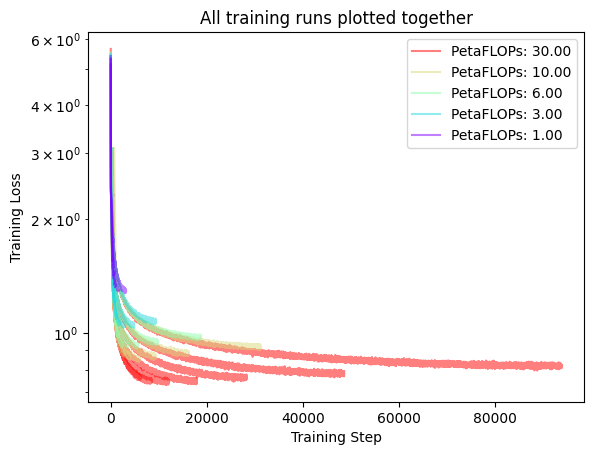

In [ ]:
REMOVE_OUTLIERS = True  # set to True to see scaling laws

# read in the loss data
name_to_flops = lambda x: float(x.split("/")[-1].split("_")[0].lstrip("flops"))
log_dirs = sorted(glob.glob(os.path.join(out_dir, "*")), key=lambda x: name_to_flops(x))
flops_to_curve = {}

min_pflops = float('inf')
max_pflops = 0
for log_dir in log_dirs:
    pflops = name_to_flops(log_dir)
    min_pflops = min(min_pflops, pflops)
    max_pflops = max(max_pflops, pflops)

cmap = plt.get_cmap('rainbow')
seen_pflops = set()

for log_dir in log_dirs[::-1]:
    with open(os.path.join(log_dir, "args.json")) as f:
        args = json.load(f)
        seq_len = args["seq_len"]
        batch_size = args["batch_size"]
    json_files = glob.glob(os.path.join(log_dir, "logs/*.json"))
    if len(json_files) == 0:
        continue
    assert len(json_files) == 1, f"{len(json_files)}"
    try:
        with open(json_files[0], "r") as f:
            data = json.load(f)
    except Exception as e:
        print(f"warning: failed to read {log_dir}")
        continue

    loss_curve = data["Loss/Train_iter_smoothed"]
    final_loss = loss_curve[-1]["value"]
    num_iters = loss_curve[-1]["step"]
    params = data["Model/Total Parameters"][-1]["value"]

    if REMOVE_OUTLIERS and final_loss > 2:
        continue

    num_peta_flops = name_to_flops(log_dir)
    name = log_dir.split("/")[-1]

    normalized_pflops = (np.log10(num_peta_flops) - np.log10(min_pflops)) / (np.log10(max_pflops) - np.log10(min_pflops))
    color = cmap(normalized_pflops)
    legend_name = None
    if num_peta_flops not in seen_pflops:
        legend_name = f"PetaFLOPs: {num_peta_flops:.2f}"
        seen_pflops.add(num_peta_flops)

    plt.plot([l["step"] for l in loss_curve], [l["value"] for l in loss_curve], color=color, label=legend_name, alpha=0.5)

    if num_peta_flops not in flops_to_curve:
        flops_to_curve[num_peta_flops] = []
    flops_to_curve[num_peta_flops].append((params, final_loss, name))

plt.yscale("log")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.legend()
plt.title("All training runs plotted together")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


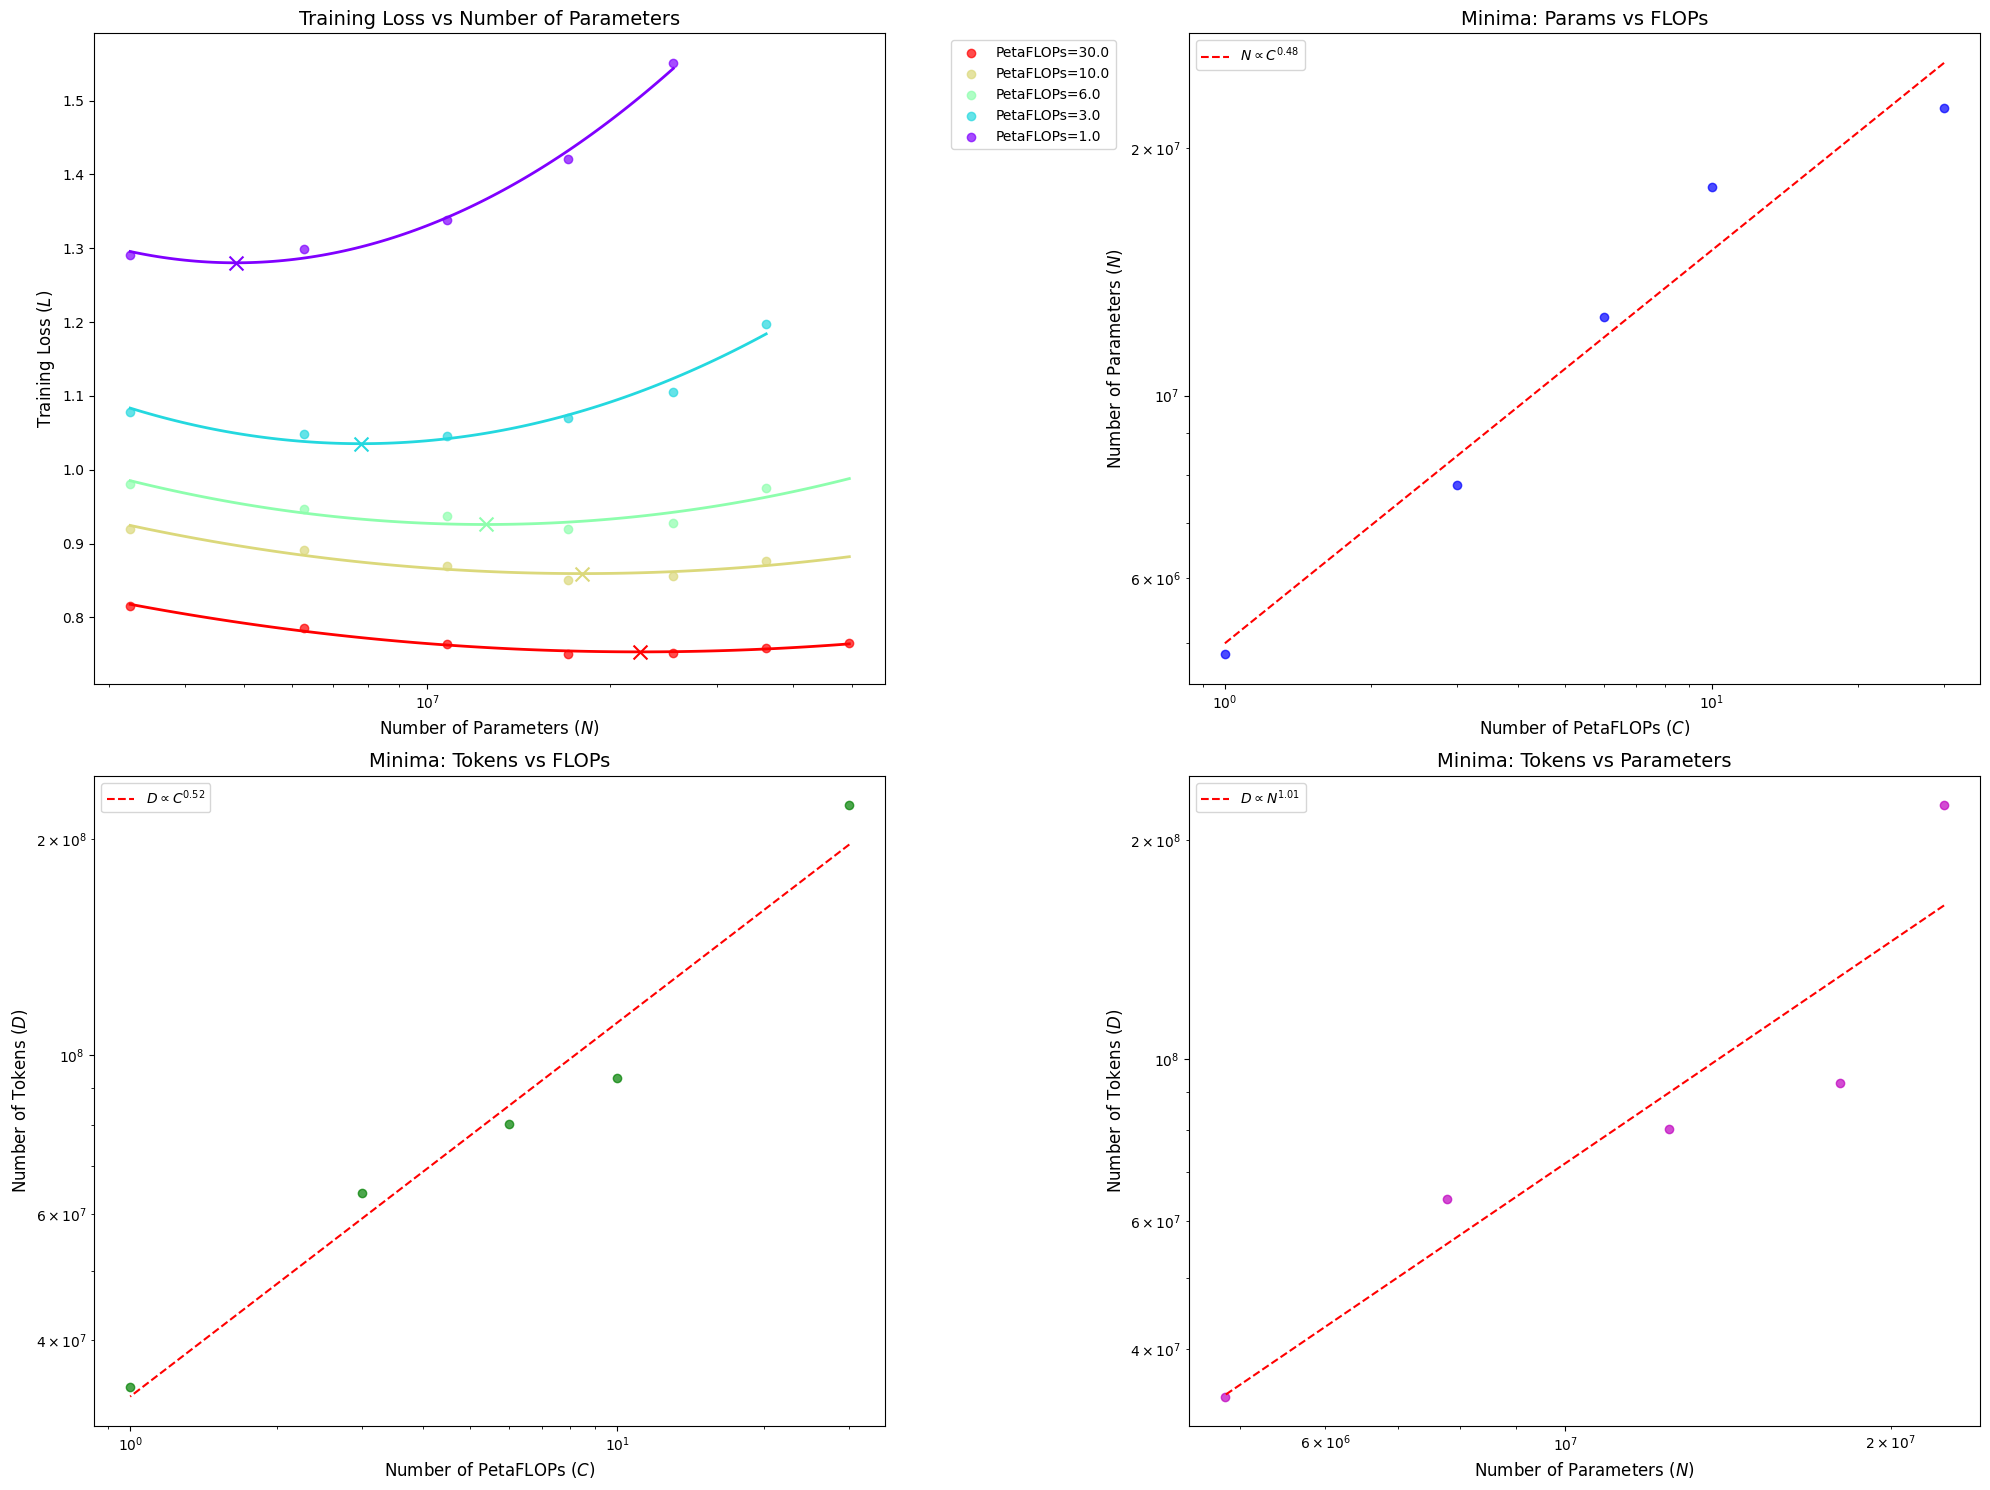

In [ ]:
polynomial_degree = 2

# Initialize lists to store minima
minima_params = []
minima_flops = []
minima_tokens = []

# Prepare the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
ax_main = axs[0, 0]
ax_flops_params = axs[0, 1]
ax_flops_tokens = axs[1, 0]
ax_params_tokens = axs[1, 1]

# Iterate through each FLOP group
for num_flops, data in flops_to_curve.items():
    xs_log = np.array([math.log10(x[0]) for x in data])
    ys = np.array([x[1] for x in data])

    X = xs_log.reshape(-1, 1)
    y = ys

    if REMOVE_OUTLIERS:
        ransac = make_pipeline(
            PolynomialFeatures(degree=polynomial_degree, include_bias=True),
            RANSACRegressor(random_state=42)
        )
        ransac.fit(X, y)

        ransac_regressor = ransac.named_steps['ransacregressor']
        inlier_mask = ransac_regressor.inlier_mask_
        X_fit = X[inlier_mask]
        y_fit = y[inlier_mask]
        poly_features = ransac.named_steps['polynomialfeatures']
        coeffs = ransac_regressor.estimator_.coef_
        intercept = ransac_regressor.estimator_.intercept_

        # Extract polynomial coefficients
        a = coeffs[2] if len(coeffs) > 2 else 0
        b = coeffs[1] if len(coeffs) > 1 else 0
        c = intercept

        # Use inliers for plotting
        X_plot = X_fit
        y_plot = y_fit
    else:
        # Use regular polynomial fitting without outlier removal
        coeffs = np.polyfit(xs_log, y, deg=polynomial_degree)
        a, b, c = coeffs  # Assuming degree=2

        # Create polynomial function
        poly = np.poly1d(coeffs)

        # All data points are considered inliers
        X_plot = X
        y_plot = y

    # Proceed only if quadratic coefficient is non-zero
    if a != 0:
        # Create polynomial function
        poly = np.poly1d([a, b, c])

        # Generate fit line
        xs_fit_log = np.linspace(min(xs_log), max(xs_log), 100)
        ys_fit = poly(xs_fit_log)
        xs_fit = 10**xs_fit_log

        # Normalize FLOPs for color mapping
        log_normalized_flops = (math.log(num_flops) - math.log(min_pflops)) / (
            math.log(max_pflops) - math.log(min_pflops) + 1e-5
        )
        color = cmap(log_normalized_flops)

        # Plot scatter points
        ax_main.scatter(
            10**X_plot.flatten(),
            y_plot,
            label=f"PetaFLOPs={num_flops}",
            color=color,
            marker='o',
            alpha=0.7
        )
        # Plot fitted polynomial
        ax_main.plot(xs_fit, ys_fit, color=color, linewidth=2)

        # Calculate and plot minima
        minima_log = -b / (2 * a)
        minima = 10**minima_log
        y_val = poly(minima_log)

        ax_main.scatter([minima], [y_val], color=color, marker="x", s=100)

        minima_params.append(minima)
        minima_flops.append(num_flops)
    else:
        print(f"pflops={num_flops}: Quadratic coefficient is zero, cannot compute minima.")

ax_main.set_xscale("log")
ax_main.set_xlabel("Number of Parameters ($N$)", fontsize=12)
ax_main.set_ylabel("Training Loss ($L$)", fontsize=12)
ax_main.set_title("Training Loss vs Number of Parameters", fontsize=14)

handles, labels = ax_main.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax_main.legend(unique.values(), unique.keys(), loc='upper right', fontsize=10, bbox_to_anchor=(1.3, 1))

ax_flops_params.scatter(minima_flops, minima_params, color='b', alpha=0.7)
m, b_fit = np.polyfit(
    [math.log10(m) for m in minima_flops],
    [math.log10(p) for p in minima_params],
    1
)
fit_line = [10**(m * math.log10(x) + b_fit) for x in minima_flops]
ax_flops_params.plot(
    minima_flops, fit_line, color='r', linestyle="--",
    label=f"$N \\propto C^{{{m:.2f}}}$"
)
ax_flops_params.set_xscale("log")
ax_flops_params.set_yscale("log")
ax_flops_params.set_xlabel("Number of PetaFLOPs ($C$)", fontsize=12)
ax_flops_params.set_ylabel("Number of Parameters ($N$)", fontsize=12)
ax_flops_params.set_title("Minima: Params vs FLOPs", fontsize=14)
ax_flops_params.legend(fontsize=10, fancybox=True)

minima_tokens = [(f * 1e15) / (6 * p) for f, p in zip(minima_flops, minima_params)]
ax_flops_tokens.scatter(minima_flops, minima_tokens, color='g', alpha=0.7)
m, b_fit = np.polyfit(
    [math.log10(m) for m in minima_flops],
    [math.log10(d) for d in minima_tokens],
    1
)
fit_line = [10**(m * math.log10(x) + b_fit) for x in minima_flops]
ax_flops_tokens.plot(
    minima_flops, fit_line, color='r', linestyle="--",
    label=f"$D \\propto C^{{{m:.2f}}}$"
)
ax_flops_tokens.set_xscale("log")
ax_flops_tokens.set_yscale("log")
ax_flops_tokens.set_xlabel("Number of PetaFLOPs ($C$)", fontsize=12)
ax_flops_tokens.set_ylabel("Number of Tokens ($D$)", fontsize=12)
ax_flops_tokens.set_title("Minima: Tokens vs FLOPs", fontsize=14)
ax_flops_tokens.legend(fontsize=10, fancybox=True)

# 3. Minima Parameters vs Minima Tokens
ax_params_tokens.scatter(minima_params, minima_tokens, color='m', alpha=0.7)
m, b_fit = np.polyfit(
    [math.log10(m) for m in minima_params],
    [math.log10(d) for d in minima_tokens],
    1
)
fit_line = [10**(m * math.log10(x) + b_fit) for x in minima_params]
ax_params_tokens.plot(
    minima_params, fit_line, color='r', linestyle="--",
    label=f"$D \\propto N^{{{m:.2f}}}$"
)
ax_params_tokens.set_xscale("log")
ax_params_tokens.set_yscale("log")
ax_params_tokens.set_xlabel("Number of Parameters ($N$)", fontsize=12)
ax_params_tokens.set_ylabel("Number of Tokens ($D$)", fontsize=12)
ax_params_tokens.set_title("Minima: Tokens vs Parameters", fontsize=14)
ax_params_tokens.legend(fontsize=10, fancybox=True)


plt.tight_layout()
plt.show()


From the above, we can see the scaling laws are roughly equal to those from Method 2 in the paper:

| Source            | Coeff. $a$ where $N_{opt} \propto C^a$ | Coeff. $b$ where $D_{opt} \propto C^b$ |
|-------------------|------------------------------------------|------------------------------------------|
| Paper (Method 2)  | 0.49                                    | 0.51                                    |
| Ours              | 0.48                                    | 0.52                                    |



## Insights

We note a few insights from this reproduction process:
1. **Outlier rejection is important:** some large models are not trained for a signifigant number of iterations, so they do not converge. This ruins the scaling laws. To get around this we: (1) Remove runs with a high final loss value, which indicates they did not converge, and (2) Use RANSAC when fitting the parabolas to remove the affect of outliers. To turn these off, set `REMOVE_OUTLIERS=False` and re-run the above code. This was not discussed in the original paper in the context of Method 2, presumably because they were working at a large enough scale and with tuned hyper-parameters that it was not an issue.
2. **Scaling laws are tricky with very small transformers:** Our original experiments included very small models (`<100K params`), but we couldn't see the scaling laws in that regime. The transformer width / depth ratios become skewed at those scales, which could have an effect. For example, all the models in these experiments had `n_layers = d_model // 64`, `n_heads = d_model // 64`, however for `d_model < 64` we can't use these simple rules.
3. We are doing **character level lanugage modelling** in this task, which is different from the token level language modelling in the original Chinchilla paper. This is mainly for practicle reasons; with characters the vocabluary is much smaller than tokens, so we can use much smaller models. Regardless, we recover a remarkably similar scaling law.

We have not seen these insights explored in prior works.